Hmo = 0.04 m, Tp = 8.51 s


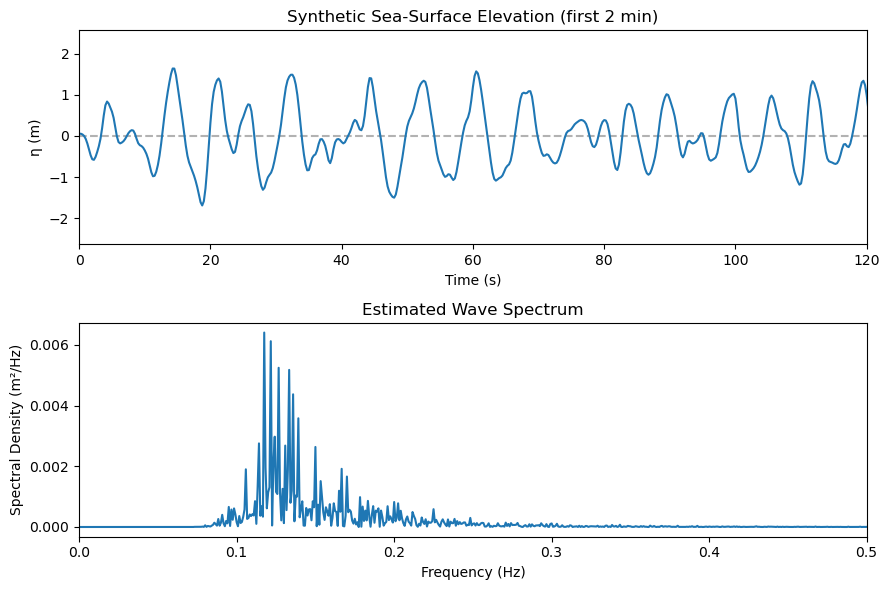

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd

# ------------------------------------------------------------
# PARAMETERS
# ------------------------------------------------------------
dt = 1/4            # 4 Hz sampling (seconds)
duration = 20*60    # 20 minutes
N = int(duration / dt)
fs = 1/dt
t = np.arange(N) * dt

Hs = 3.0            # target significant wave height (m)
Tp = 8.0            # target peak period (s)
gamma = 3.3         # JONSWAP peakedness
g = 9.81

# ------------------------------------------------------------
# JONSWAP spectrum (m^2/Hz)
# ------------------------------------------------------------
f = np.linspace(0.02, 1.0, N//2+1)
fp = 1/Tp
alpha = 0.076 * (Hs**2 * fp**4 / g**2)**0.22  # standard JONSWAP alpha formulation

sigma = np.where(f <= fp, 0.07, 0.09)
r = np.exp(-0.5 * ((f - fp)/ (sigma * fp))**2)
S = alpha * g**2 * (2*np.pi)**(-4) * f**(-5) * np.exp(-1.25*(fp/f)**4) * gamma**r
S[f==0] = 0

# ------------------------------------------------------------
# Generate random phases and synthesize surface elevation
# ------------------------------------------------------------
df = f[1]-f[0]
a = np.sqrt(2*S*df)        # amplitude for each component
phase = 2*np.pi*np.random.rand(len(f))
eta = np.sum(a[:, None] * np.cos(2*np.pi*f[:,None]*t + phase[:,None]), axis=0)

# ------------------------------------------------------------
# Verify spectral properties
# ------------------------------------------------------------
eta -= np.mean(eta) # remove the mean
Nfft = len(eta)
E = np.fft.rfft(eta)
S_est = (2/(Nfft**2*fs)) * np.abs(E)**2
S_est[0] /= 2
f_est = np.fft.rfftfreq(Nfft, d=dt)

m0 = integrate.trapezoid(S_est, f_est)
Hmo = 4*np.sqrt(m0)
fp_est = f_est[np.argmax(S_est)]
Tp_est = 1/fp_est

print(f"Hmo = {Hmo:.2f} m, Tp = {Tp_est:.2f} s")

# ------------------------------------------------------------
# PLOTS
# ------------------------------------------------------------
fig, axs = plt.subplots(2,1, figsize=(9,6))
axs[0].plot(t, np.zeros_like(t), '--', c='gray', alpha=0.6 )
axs[0].plot(t, eta)
axs[0].set_xlim(0,120)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('η (m)')
axs[0].set_title('Synthetic Sea-Surface Elevation (first 2 min)')

axs[1].plot(f_est, S_est)
axs[1].set_xlim(0, 0.5)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Spectral Density (m²/Hz)')
axs[1].set_title('Estimated Wave Spectrum')
plt.tight_layout()
plt.show()

# Save the time series
df = pd.DataFrame({'time_s': t, 'eta_m': eta})
df.to_csv('synthetic_sea_surface_3m8s_4Hz_20min.csv', index=False)
